In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pycountry
import plotly.express as px


In [24]:
plt.style.use("seaborn-v0_8-whitegrid")

# Load your data
df = pd.read_csv("GlobalWeatherCleaned.csv")  # change file name

# Parse datetime
df["last_updated"] = pd.to_datetime(df["last_updated"])

# Basic time helpers
df["date"] = df["last_updated"].dt.date
df["year_month"] = df["last_updated"].dt.to_period("M").dt.to_timestamp()

# Key metrics for visuals
metrics = [
    "temperature_celsius",
    "humidity",
    "precip_mm",
    "wind_kph",
    "uv_index",
    "air_quality_PM2.5",
]


1️⃣ Choropleth Map – Average Temperature by Country

Outstanding for giving a global picture 🌍

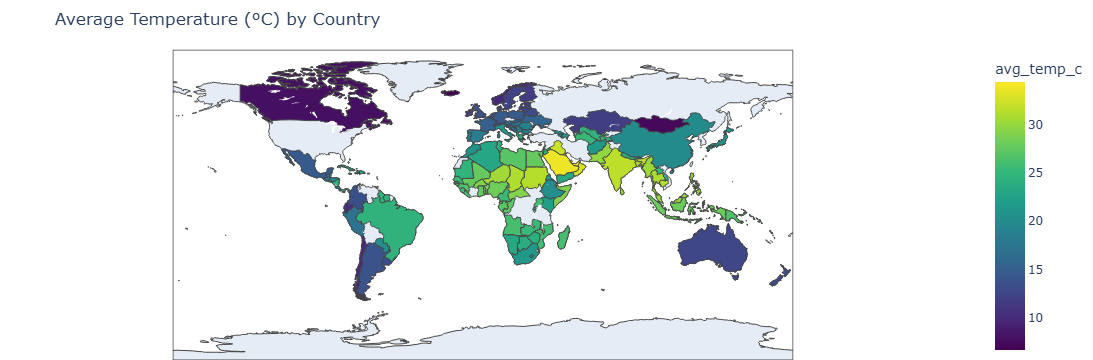

In [32]:
# Function to convert country name → ISO-3 code
def get_iso3(country_name):
    try:
        return pycountry.countries.get(name=country_name).alpha_3
    except:
        return None  # Return None if not found

# Country-level mean temperature
country_temp = (
    df.groupby("country", as_index=False)["temperature_celsius"]
      .mean()
      .rename(columns={"temperature_celsius": "avg_temp_c"})
)

# Add ISO codes column
country_temp["iso_code"] = country_temp["country"].apply(get_iso3)

# Drop rows where ISO code was not found
country_temp = country_temp.dropna(subset=["iso_code"])

# Plot using ISO-3 codes
fig = px.choropleth(
    country_temp,
    locations="iso_code",         # ← use ISO-3 instead of names
    locationmode="ISO-3",
    color="avg_temp_c",
    hover_name="country",
    title="Average Temperature (°C) by Country",
    color_continuous_scale="Viridis",
)

fig.update_layout(
    margin=dict(l=0, r=0, t=50, b=0)
)

fig.show()


3️⃣ Scatterplot – Temperature vs PM2.5 (Air Quality)
Shows health–climate relationship clearly ⚪

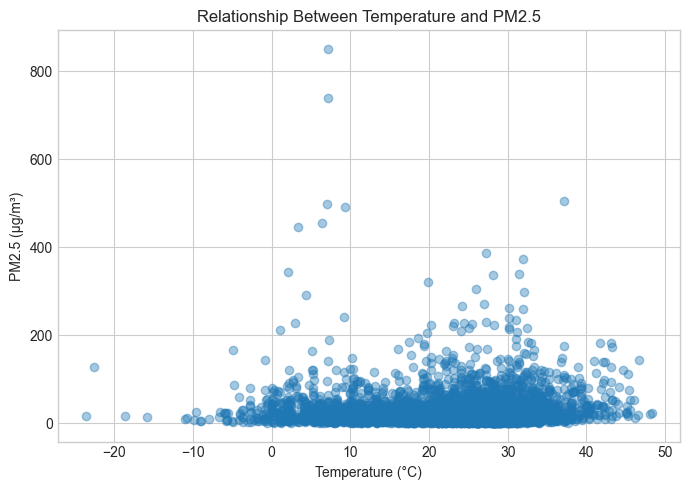

In [26]:
# Sample to avoid overplotting if dataset is very large
sample = df.sample(n=5000, random_state=42) if len(df) > 5000 else df

fig, ax = plt.subplots(figsize=(7, 5))
ax.scatter(
    sample["temperature_celsius"],
    sample["air_quality_PM2.5"],
    alpha=0.4
)

ax.set_title("Relationship Between Temperature and PM2.5")
ax.set_xlabel("Temperature (°C)")
ax.set_ylabel("PM2.5 (µg/m³)")
plt.tight_layout()
plt.show()


“Higher temperatures tend to be associated/not associated with worse air quality…”

4️⃣ Heatmap – Compare Countries Across Multiple Metrics

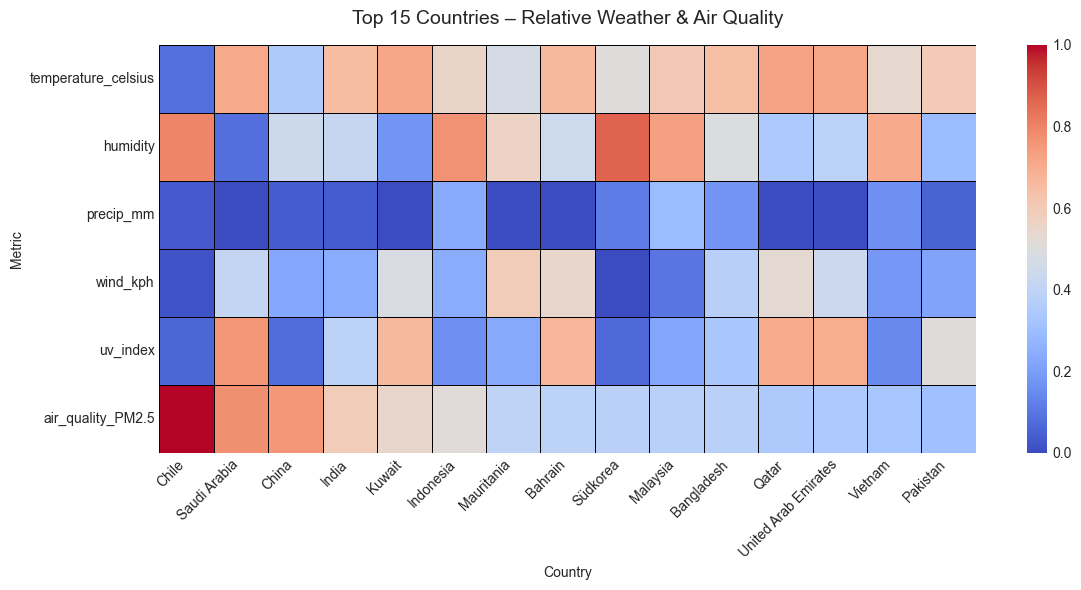

In [29]:
metrics_to_show = [
    "temperature_celsius",
    "humidity",
    "precip_mm",
    "wind_kph",
    "uv_index",
    "air_quality_PM2.5",
]
plt.rcParams["font.family"] = "DejaVu Sans"
plt.style.use("seaborn-v0_8-whitegrid")

# Country-level averages
country_mean = (
    df.groupby("country", as_index=False)[metrics_to_show]
      .mean()
)

# Normalize 0–1 for each metric
norm = country_mean.copy()
for m in metrics_to_show:
    col_min = norm[m].min()
    col_max = norm[m].max()
    norm[m] = (norm[m] - col_min) / (col_max - col_min + 1e-9)

heat_df = norm.set_index("country")
top_n = 15
top_countries = (
    country_mean
    .sort_values("air_quality_PM2.5", ascending=False)
    ["country"]
    .head(top_n)
)

heat_small = heat_df.loc[top_countries, metrics_to_show]
# Transpose so: rows = metrics, columns = countries
heat_plot = heat_small.T

plt.figure(figsize=(12, 6))
sns.heatmap(
    heat_plot,
    cmap="coolwarm",
    linewidths=0.6,
    linecolor="black",
    cbar=True,
    annot=False  # set True if you want numbers inside
)

plt.title("Top 15 Countries – Relative Weather & Air Quality", fontsize=14, pad=15)
plt.xlabel("Country")
plt.ylabel("Metric")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
